# Train Forecast Model - Daily

In this notebook we'll train a deep learning model that learns if a target price or stop loss would be hit for a long/short trade in the next days based on historical price data.

Model:
* Multilayer Perceptron (MLP) (Feedforward neural network)
* 3 layers: input, hidden, output
* Binary Classification
* `Input`: Close, SMA(2 to 16), ROC(2 to 16)
* `Output`: Does a long or short trade hit the profit target (2%) without hitting a stop loss (1.5%) in the next five days?

In [1]:
%run ../2_Strategies/init_model.py 'model_long_short_predict'

model_long_short_predict


In [2]:
%%writefile local/{model_name}/input/config/hyperparameters.json
{ 
}

Overwriting local/model_long_short_predict/input/config/hyperparameters.json


# Step 1) Get Data from Athena and S3

In [3]:
# get S3 bucket
s3bucket=!(aws s3 ls | grep algotrading- | awk  '{print $3}')
s3bucket=s3bucket[0]
s3bucket

'algotrading-s3bucket-azmm1l7vqnf6'

In [4]:
import sys
!{sys.executable} -m pip install PyAthena

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [5]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()
region = sess.boto_session.region_name

In [6]:
import pandas as pd
from pyathena import connect
conn = connect(s3_staging_dir='s3://'+s3bucket+'/results/',
               region_name=region)

df = pd.read_sql("SELECT * FROM algo_data.hist_data_daily;", conn)
df.set_index(pd.DatetimeIndex(df['dt']),inplace=True)
del df['dt']
df.head()

,sym,open,high,low,close,vol
dt,,,,,,
2012-08-13,INTC,26.76,26.83,26.41,26.69,23623918.0
2012-08-14,INTC,26.80,26.81,26.38,26.48,27477260.0
2012-08-15,INTC,26.23,26.47,26.19,26.27,26081909.0
2012-08-16,INTC,26.44,26.65,26.34,26.59,25702363.0
2012-08-17,INTC,26.57,26.63,26.21,26.33,30379903.0


In [7]:
df.to_csv('local/'+model_name+'/input/data/training/data_orig.csv')
print("count=%s" % len(df))
df.head()

count=7025


,sym,open,high,low,close,vol
dt,,,,,,
2012-08-13,INTC,26.76,26.83,26.41,26.69,23623918.0
2012-08-14,INTC,26.80,26.81,26.38,26.48,27477260.0
2012-08-15,INTC,26.23,26.47,26.19,26.27,26081909.0
2012-08-16,INTC,26.44,26.65,26.34,26.59,25702363.0
2012-08-17,INTC,26.57,26.63,26.21,26.33,30379903.0


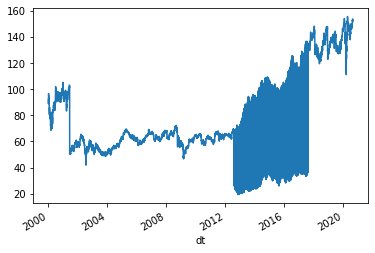

In [8]:
%matplotlib notebook
%matplotlib inline
df["close"].plot()

# Step 2) Run Data Preparation Locally

## Modify Data Preparation Code

In the following cell, you can modify the data preparation code or leave it as is.

In [9]:
%%writefile model/{model_name}_prep.py
#!/usr/bin/env python

import numpy as np
import pandas as pd
import talib as ta
from talib.abstract import *
import math

prefix = '/opt/ml/'
input_path = prefix + 'input/data/training'

data_orig_file = input_path+'/data_orig.csv'
data_file = input_path+'/data.csv'

d = pd.read_csv(data_orig_file,infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])
print(d.head())

repeatCount=15
repeatStep=1
lookBack=repeatCount*repeatStep
forwardWindow=5

profitTarget=2.0/100.0
stopTarget=1.5/100.0

iCount=lookBack

# header
hData=["dt"]
hData.append("close") 
for a in range(0,repeatCount):
    hData.append("wvma"+str((a+2)*repeatStep))
for a in range(0,repeatCount):
    hData.append("atr"+str((a+2)*repeatStep))
for a in range(0,repeatCount):
    hData.append("rsi"+str((a+2)*repeatStep))
for a in range(0,repeatCount):
    hData.append("sma"+str((a+2)*repeatStep))
for a in range(0,repeatCount):
    hData.append("roc"+str((a+2)*repeatStep))
hData.append("long")
hData.append("short")
print(hData)

# data
tData=[]
inputs = {
    'close': np.array(d["close"]),
    'high': np.array(d["high"]),
    'low': np.array(d["low"]),
    'volume': np.array(d["vol"])
}
vwma=[]
for a in range(0,repeatCount):
    vwma.append(WMA(inputs,timeperiod=(a+1)*repeatStep+1))
atr=[]
for a in range(0,repeatCount):
    atr.append(ATR(inputs,timeperiod=(a+1)*repeatStep+1))
rsi=[]
for a in range(0,repeatCount):
    rsi.append(RSI(inputs,timeperiod=(a+1)*repeatStep+1))
sma=[]
for a in range(0,repeatCount):
    sma.append(SMA(inputs,timeperiod=(a+1)*repeatStep+1))
roc=[]
for a in range(0,repeatCount):
    roc.append(ROC(inputs,timeperiod=(a+1)*repeatStep+1))

closeList=d["close"]
dLen=len(d)
n=0
lCount=0
sCount=0
nCount=0
n=0
for idx,row in d.iterrows():
    if n<dLen-forwardWindow-1:
        dt1=idx
        cl=row["close"]
        inputRec=[]
        inputRec.append(idx)

        inputRec0=[]

        #close
        inputRec0.append(cl)
        #vwma
        for a in range(0,repeatCount):
            if math.isnan(vwma[a][n]):
                inputRec0.append(cl)
            else:
                inputRec0.append(vwma[a][n])
        #atr
        for a in range(0,repeatCount):
            if math.isnan(atr[a][n]):
                inputRec0.append(cl)
            else:
                inputRec0.append(atr[a][n])
                
        #rsi
        for a in range(0,repeatCount):
            if math.isnan(rsi[a][n]):
                inputRec0.append(cl)
            else:
                inputRec0.append(rsi[a][n])
        
    
                
        #sma
        for a in range(0,repeatCount):
            if math.isnan(sma[a][n]):
                inputRec0.append(cl)
            else:
                inputRec0.append(sma[a][n])

        m1=min(inputRec0)
        m2=max(inputRec0)
        for a in inputRec0:
            if m2-m1==0:
                inputRec.append(0)
            else:
                inputRec.append((a-m1)/(m2-m1))

        #roc
        for a in range(0,repeatCount):
            if math.isnan(roc[a][n]):
                inputRec.append(0)
            else:
                inputRec.append(roc[a][n])
                
        rClose=closeList[n+1:min(dLen-1,n+1+forwardWindow)].values.tolist()
        low=min(rClose)
        high=max(rClose)
        
            
        
        #long
        long=0
        if high>=cl+cl*profitTarget and low>=cl-cl*stopTarget:
            long=1
            lCount=lCount+1
        inputRec.append(long)
 
        #short
        short=0
        if low<=cl-cl*profitTarget and high<=cl+cl*stopTarget:
            short=1
            sCount=sCount+1
        inputRec.append(short)

        tData.append(inputRec)
        n=n+1
          
print("lCount=%s,sCount=%s" % (lCount,sCount))
df1=pd.DataFrame(tData,columns=hData)
df1.set_index(pd.DatetimeIndex(df1['dt']), inplace=True)
del df1['dt']
 
df1.to_csv(data_file)
print(df1.head())
print("count=%s" % (len(df1)))

Overwriting model/model_long_short_predict_prep.py


## Run Data Preparation Locally in a Docker Container

In [10]:
!cp model/{model_name}_prep.py model/train
!chmod 777 model/train
!docker build -t {model_name}_prep .
!docker run -v $(pwd)/local/$model_name:/opt/ml --rm {model_name}_prep train

Sending build context to Docker daemon  29.15MB
Step 1/23 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/23 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> c18207f35189
Step 3/23 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> d057f1dca15b
Step 4/23 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py
 ---> Using cache
 ---> 09934ea62a85
Step 5/23 : RUN pip install numpy
 ---> Using cache
 ---> 009ba349edbd
Step 6/23 : RUN pip install scipy
 ---> Using cache
 ---> f0185befba4d
Step 7/23 : RUN pip install scikit-learn
 ---> Using cache
 ---> 2093f8f14efd
Step 8/23 : RUN pip i

## Create Training and Test Data

In [11]:
df = pd.read_csv("local/"+model_name+"/input/data/training/data.csv", infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])
print("totalCount=%s" % len(df))

trainCount=int(len(df)*0.4)
dfTrain = df.iloc[:trainCount]
dfTrain.to_csv("local/"+model_name+"/input/data/training/data_train.csv")
print("trainCount=%s" % len(dfTrain))

dfTest = df.iloc[trainCount:]
dfTest.to_csv("local/"+model_name+"/input/data/training/data_test.csv")
print("testCount=%s" % len(dfTest))
dfTest.head()

totalCount=7019
trainCount=2807
testCount=4212


,close,wvma2,wvma3,wvma4,wvma5,wvma6,wvma7,wvma8,wvma9,wvma10,...,roc9,roc10,roc11,roc12,roc13,roc14,roc15,roc16,long,short
dt,,,,,,,,,,,,,,,,,,,,,
2003-12-01,0.969985,0.968653,0.969319,0.971962,0.975524,0.978269,0.980863,0.983606,0.986093,0.988215,...,-4.199729,-5.026861,-1.668653,0.000000,0.855746,1.580135,1.413645,0.671141,0,0
2003-12-02,0.962420,0.966082,0.967247,0.968611,0.971061,0.974222,0.976871,0.979424,0.982103,0.984585,...,-5.756642,-5.264177,-6.082118,-2.761224,-1.111111,-0.264874,0.451467,0.286826,1,0
2003-12-03,0.969183,0.967785,0.968917,0.969563,0.970515,0.972360,0.974889,0.977161,0.979431,0.981856,...,-5.931879,-5.352330,-4.857751,-5.679202,-2.344060,-0.686869,0.162999,0.882413,1,0
2003-12-04,0.830599,0.829635,0.828557,0.828727,0.828886,0.829343,0.830460,0.832131,0.833724,0.835378,...,-4.194989,-5.606582,-5.025029,-4.528740,-5.353031,-2.006357,-0.343434,0.509372,0,0
2003-12-05,0.972968,0.974104,0.974104,0.973569,0.973770,0.973960,0.974414,0.975490,0.977137,0.978766,...,-3.380503,-4.525151,-5.931879,-5.352330,-4.857751,-5.679202,-2.344060,-0.686869,1,0


# Step 3) Train the Model

In the following cell, you can modify the model training code or leave it as is.

In [12]:
%%writefile model/{model_name}.py
#!/usr/bin/env python
from __future__ import print_function

import os
import sys
import traceback
import math
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.layers import Dropout, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

yLen=2
b=0

# Optional
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# These are the paths to where SageMaker mounts interesting things in your
# container.
prefix = '/opt/ml/'

input_path = prefix + 'input/data/training/data_train.csv'
test_path = prefix + 'input/data/training/data_test.csv'

output_path = os.path.join(prefix, 'output')
model_path = os.path.join(prefix, 'model')

# Process and prepare the data
def data_process(df):
    global yLen
    global b
    dataX=[]
    dataY=[]
    for idx,row in df.iterrows():
        row1=[]
        r=row[1:len(row)-yLen]
        for a in r:
            row1.append(a)
        x=np.array(row1)
        y=np.array(row[len(row)-yLen:])
        b=len(x)
        dataX.append(x)
        dataY.append(y)
    dataX=np.array(dataX).astype(np.float32)
    dataY=np.array(dataY).astype(np.float32)
    return dataX,dataY,b

def build_classifier():
    global b
    global yLen
    print("build_classifier:b=%s,yLen=%s" % (b,yLen))
    model = Sequential()
    model.add(Dense(b, input_dim=b, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(b/2), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(yLen,kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def generate_model(dataX, dataY, b):
    model=build_classifier()
    model.fit(dataX, dataY, epochs=100, batch_size=1)
    scores = model.evaluate(dataX, dataY, verbose=0)
    print("Training Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    return model
        
def train():
    print('Starting the training.')
    try:
        raw_data = pd.read_csv(input_path)
        #print(raw_data)
        X, y, b = data_process(raw_data)
        model = generate_model(X, y, b)
        model.save(os.path.join(model_path, 'model.h5'))
        
        print('Training is complete. Model saved.')
        
        raw_data = pd.read_csv(test_path)
        testX, testY, b = data_process(raw_data)
        scores = model.evaluate(testX, testY, verbose=0)
        print("Test Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
    except Exception as e:
        # Write out an error file. This will be returned as the failure
        # Reason in the DescribeTrainingJob result.
        trc = traceback.format_exc()
        with open(os.path.join(output_path, 'failure'), 'w') as s:
            s.write('Exception during training: ' + str(e) + '\n' + trc)
        # Printing this causes the exception to be in the training job logs
        print(
            'Exception during training: ' + str(e) + '\n' + trc,
            file=sys.stderr)
        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)

if __name__ == '__main__':
    train()

    # A zero exit code causes the job to be marked a Succeeded.
    sys.exit(0)

Overwriting model/model_long_short_predict.py


In [13]:
!docker images

REPOSITORY                                                              TAG                 IMAGE ID            CREATED             SIZE
173951039606.dkr.ecr.us-east-1.amazonaws.com/model_long_short_predict   latest              c1081251f6ff        About an hour ago   6.69GB
model_long_short_predict                                                latest              c1081251f6ff        About an hour ago   6.69GB
model_long_short_predict_prep                                           latest              3f5ffbe3f98a        About an hour ago   6.69GB
173951039606.dkr.ecr.us-east-1.amazonaws.com/model_long_short_predict   <none>              cb35a7035fa3        About an hour ago   6.69GB
<none>                                                                  <none>              9cf14168d9de        About an hour ago   6.69GB
173951039606.dkr.ecr.us-east-1.amazonaws.com/model_long_short_predict   <none>              6699dce1d8c8        2 hours ago         6.69GB
<none>                       

### Option 1: Train Locally

You can choose if you want to do the training locally (Option 1) or remote via SageMaker (Option 2).

In [14]:
# Build Local ML Image
!cp model/{model_name}.py model/train
!chmod 777 model/train
!docker build -t {model_name} .
!docker run -v $(pwd)/local/$model_name:/opt/ml --rm {model_name} train

Sending build context to Docker daemon  26.27MB
Step 1/23 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/23 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> c18207f35189
Step 3/23 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> d057f1dca15b
Step 4/23 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py
 ---> Using cache
 ---> 09934ea62a85
Step 5/23 : RUN pip install numpy
 ---> Using cache
 ---> 009ba349edbd
Step 6/23 : RUN pip install scipy
 ---> Using cache
 ---> f0185befba4d
Step 7/23 : RUN pip install scikit-learn
 ---> Using cache
 ---> 2093f8f14efd
Step 8/23 : RUN pip i

#### Copy Model Artifact to Strategies Folder

In [15]:
!ls -la local/{model_name}/model/model.h5
!cp local/{model_name}/model/model.h5 ../2_Strategies/model/{model_name}.h5
!ls -la ../2_Strategies/model/model_*.h5

-rw-r--r-- 1 root root 139232 Aug 16 20:57 local/model_long_short_predict/model/model.h5
-rw-rw-r-- 1 ec2-user ec2-user 139232 Aug 16 20:57 ../2_Strategies/model/model_long_short_predict.h5
-rw-rw-r-- 1 ec2-user ec2-user  32544 Aug 12 16:54 ../2_Strategies/model/model_long_short_predict_intraday.h5


### Option 2: Remote Training via SageMaker

You can choose if you want to do the training locally (Option 1) or remote via SageMaker (Option 2).

In [16]:
# Deploy ML Image to ECS
!./build_and_push.sh $model_name

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon   26.3MB
Step 1/23 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/23 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> c18207f35189
Step 3/23 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> d057f1dca15b
Step 4/23 : RUN wget https://bootstrap.pyp

In [17]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local/'+model_name+'/input/data/training'
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

conf_file='local/'+model_name+'/input/config/hyperparameters.json'
with open(conf_file, 'r') as f:
    config = json.load(f)
print(config)

prefix=model_name
job_name=prefix.replace('_','-')

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

classifier = sage.estimator.Estimator(
    image_uri=image,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name)
classifier.fit(data_location)

s3://sagemaker-us-east-1-173951039606/data
{}
2021-08-16 20:57:48 Starting - Starting the training job...
2021-08-16 20:58:11 Starting - Launching requested ML instancesProfilerReport-1629147467: InProgress
......
2021-08-16 20:59:11 Starting - Preparing the instances for training.........
2021-08-16 21:00:48 Downloading - Downloading input data
2021-08-16 21:00:48 Training - Downloading the training image.......
2021-08-16 21:09:54 Uploading - Uploading generated training model
2021-08-16 21:09:54 Completed - Training job completed
ProfilerReport-1629147467: NoIssuesFound
Training seconds: 552
Billable seconds: 552


#### Download Model Artifact from Amazon S3 and copy it to Strategies Folder

In [18]:
#Get Model from S3
model_name_s3=classifier.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name_s3,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
!cp model.h5 ../2_Strategies/model/{model_name}.h5
!ls -la model.h5
!ls -la ../2_Strategies/model/model_*.h5